In [1]:
from collections import defaultdict

import utility
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import statistics 

In [2]:
input_file = '80beers_moraca_experiment_generator_normal_prior_normal.csv'
input = {
    #20: 'housing20time.csv',
    #30: 'housing30time.csv',
    30: input_file
}

# Functions below try to retrieve the informations which they need using regex on input_file. If they failed
# than variabile will be initialized with value in except part
try:
    family = utility.get_family_name(input_file)
except:
    family = 'housing'
    
try:
    generator_prior = get_generator_prior(input_file)
except:
    generator_prior = 'generator_uniform_prior_uniform'
    
try:
    item_count = utility.get_item_count(input_file)
except:
    item_count = 30



In [3]:
filters, recommenders, vois, data = utility.read_input_files(input)

voiName = utility.get_voi_name()
filterName = utility.get_filter_name()
recName = utility.get_rec_name()
voiStyle = utility.get_voi_style()
filterStyle = utility.get_filter_style()
recStyle = utility.get_rec_style()
queriesList = utility.get_queries_list(data)

distribution_of_true_top = utility.get_frequency_of_true_tops(filters, recommenders, vois, data)
print("Distribution of true tops (%)")
print(distribution_of_true_top)

userCount = utility.get_user_count(data)

voiPerformanceDict, globalPerformanceDict, wrongRecCountDict = utility.calculate_voi_and_global_performance(data) 
voiAccuracyDict = utility.calculate_regret_for_each_recommendation(data)
    
resultDict = defaultdict(list) 
for k,v in voiPerformanceDict.items():
    for u,z in voiPerformanceDict[k].items():
        resultDict[u].append(u[0])
        resultDict[u].append(u[1])
        resultDict[u].append(u[2])
        resultDict[u].append(u[3])
        resultDict[u].append(statistics.mean(voiPerformanceDict[k][u]))
        resultDict[u].append(statistics.stdev(voiPerformanceDict[k][u]))
        resultDict[u].append((sum(wrongRecCountDict[k][u])*100)/userCount)
        resultDict[u].append(statistics.mean(voiAccuracyDict[k][u]))
        resultDict[u].append(statistics.stdev(voiAccuracyDict[k][u]))

#Creo il dataframe di output
result = pd.DataFrame.from_dict(resultDict, orient='index', 
                                columns=['recommender', 'filter', 'selector', 'query_n',
                                         'average_time', 'stdev_time', 'error_percent', 'average_diff', 'stdev_diff'])    

# print(result)
# print('\n')

# Time performance over all queries
globalPerformance = {}
for k,v in globalPerformanceDict.items():
    for u,z in globalPerformanceDict[k].items():
        globalPerformance[u] = [u[0], u[1], u[2], 
                           statistics.mean(globalPerformanceDict[k][u]),
                                             statistics.stdev(globalPerformanceDict[k][u])]
globalPerformanceTable = pd.DataFrame.from_dict(globalPerformance, orient='index', 
                                columns=['recommender', 'filter', 'selector', 'average_time', 'stddev_time'])
       
print(globalPerformanceTable)

Distribution of true tops (%)
{15: 26.424166666666668, 24: 13.8125, 6: 4.8125, 48: 14.933333333333334, 33: 2.488333333333333}
                     recommender filter selector  average_time  stddev_time
( Valr,  SqR,  RNDs)        Valr    SqR     RNDs      0.000000     0.000000
( ReVr,  SqR,  ReVs)        ReVr    SqR     ReVs      0.317782     0.088644
( ReVr,  SqR,  TTEs)        ReVr    SqR     TTEs      0.002831     0.004514
( Valr,  SqR,  TTEs)        Valr    SqR     TTEs      0.003421     0.004749
( Valr,  SqR,  Vals)        Valr    SqR     Vals      0.233902     0.033081
( Valr,  TWA,  RNDs)        Valr    TWA     RNDs      0.000000     0.000000
( ReVr,  TWA,  ReVs)        ReVr    TWA     ReVs      0.679608     0.161969
( ReVr,  TWA,  TTEs)        ReVr    TWA     TTEs      0.010206     0.001860
( Valr,  TWA,  TTEs)        Valr    TWA     TTEs      0.010238     0.001971
( Valr,  TWA,  Vals)        Valr    TWA     Vals      0.460890     0.083559
( Valr,  Tp2,  RNDs)        Valr    Tp

In [4]:
globalPerformanceTable.to_csv(family + str(item_count) + generator_prior + "-" "time.csv")

In [5]:
#g=globalPerformanceTable
#h=g[(g['recommender']==' AbRr') & (g['selector']!=' RNDs')]
#h.iloc[0].average_time

**Grafico di comparazione dell'errore percentuale dei VOI**

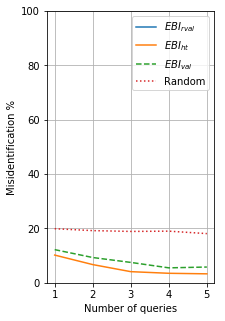

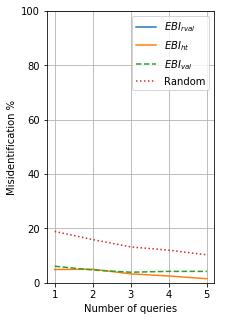

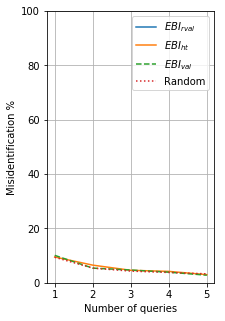

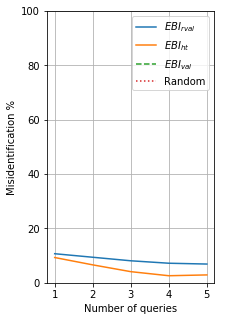

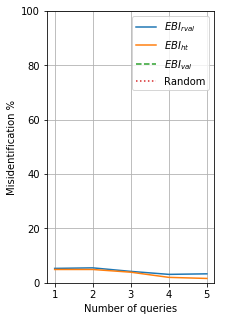

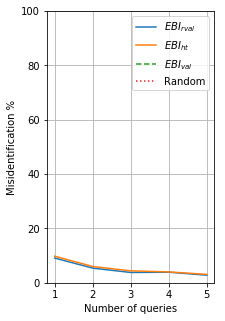

In [6]:
# A Fig. for each recommender and filter
for recom in recommenders:
    for filt in filters:
    
        fig = plt.figure(figsize=(3,5))
        ax = fig.subplots()
        
        # Selector-based figure: fixed filter and recommender    
        for voi in vois:
            x_axis = [] 
            y_axis = [] 
    
            for index, row in result.iterrows():       
                if row["selector"] == voi and row["filter"] == filt and row['recommender'] == recom :
                    x_axis.append(row["query_n"])
                    y_axis.append(row["error_percent"])
            ax.plot(x_axis, y_axis, label=voiName[voi.strip()], linestyle=voiStyle[voi.strip()])
        
        # Title of the Fig. 
        filename = "misidentification-fig-" + family + "-selectors" + recom + filt + generator_prior + ".pdf"
        filename=filename.replace(" ", "-")
        
        ax.set(xlabel='Number of queries', xticks=queriesList, ylabel='Misidentification %')
        ax.grid()
        ax.legend() # title="BIs"
        plt.ylim(bottom=0, top=100)
        plt.show()
                
        # Fig. generation
        fig.savefig(filename, pad_inches=0, bbox_inches='tight')

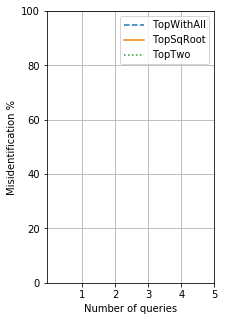

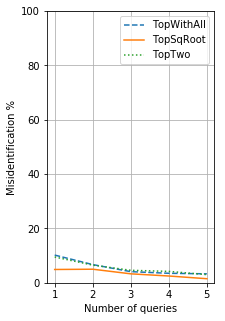

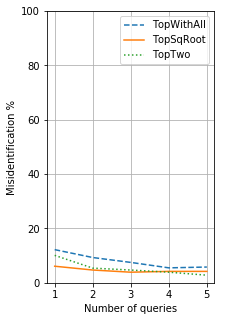

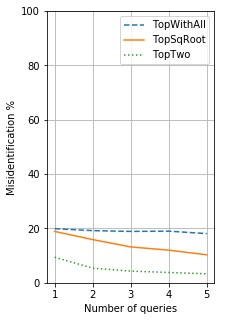

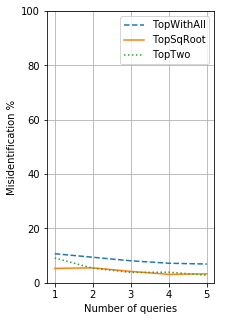

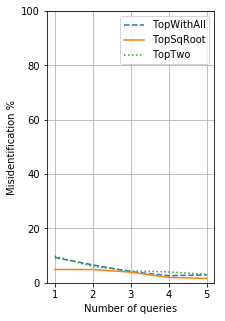

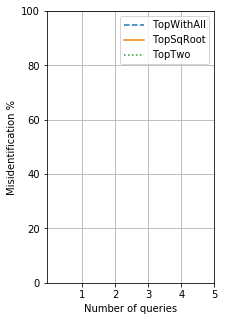

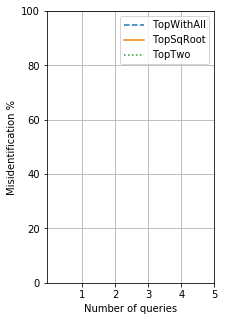

In [7]:
# Comparing filters
for recom in recommenders:
    for voi in vois:
            
        fig = plt.figure(figsize=(3,5))
        ax = fig.subplots()
        
        for filt in filters:
        # Selector-based figure: fixed voi and recommender    
            x_axis = [] 
            y_axis = [] 
    
            for index, row in result.iterrows():       
                if row["selector"] == voi and row["filter"] == filt and row['recommender'] == recom :
                    x_axis.append(row["query_n"])
                    y_axis.append(row["error_percent"])
    
            indexLineStyle = list(filters).index(filt) + 1
            ax.plot(x_axis, y_axis, label=filterName[filt.strip()], linestyle=filterStyle[filt.strip()])
        
        # Title of the Fig. 
        filename = "misidentification-fig-" + family + "-filters" + recom + voi + generator_prior + ".pdf"
        filename = filename.replace(" ", "-")
        
        ax.set(xlabel='Number of queries', xticks=queriesList, ylabel='Misidentification %')
        ax.grid()
        ax.legend() # title="BIs"
        plt.ylim(bottom=0, top=100)
        plt.show()
                
        # Fig. generation
        fig.savefig(filename, pad_inches=0, bbox_inches='tight')

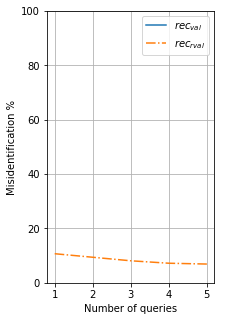

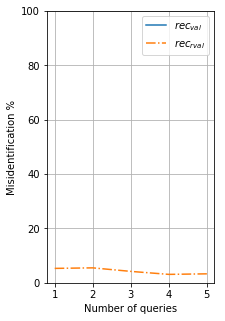

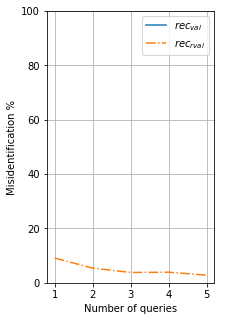

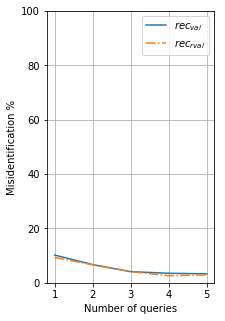

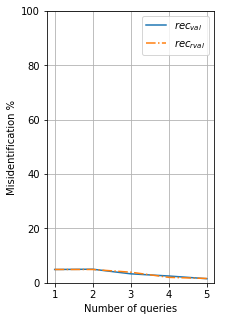

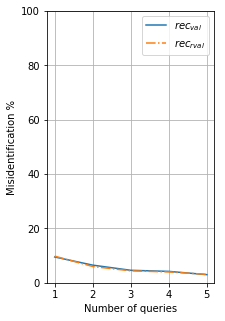

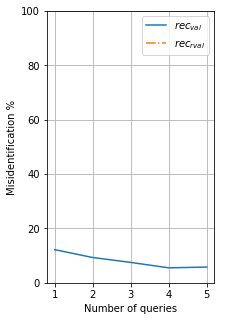

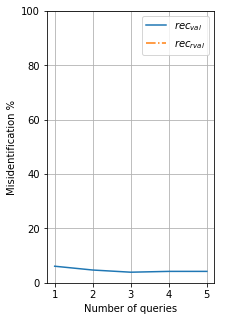

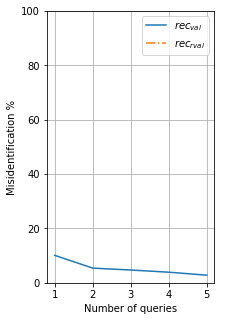

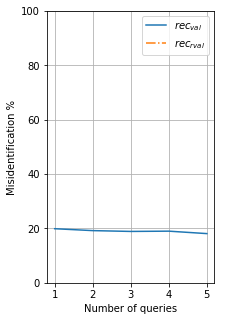

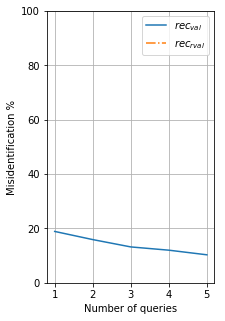

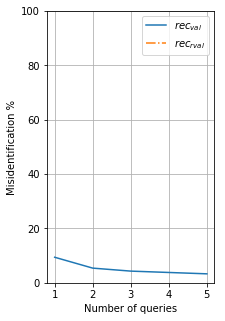

In [8]:
# Comparing recommenders
for voi in vois:
    for filt in filters:
            
        fig = plt.figure(figsize=(3,5))
        ax = fig.subplots()
        
        for recom in recommenders:
        # Selector-based figure: fixed voi and recommender    
            x_axis = [] 
            y_axis = [] 
    
            for index, row in result.iterrows():       
                if row["selector"] == voi and row["filter"] == filt and row['recommender'] == recom :
                    x_axis.append(row["query_n"])
                    y_axis.append(row["error_percent"])
    
            indexLineStyle = list(filters).index(filt) + 1
            ax.plot(x_axis, y_axis, label=recName[recom.strip()], linestyle=recStyle[recom.strip()])
        
        # Title of the Fig. 
        filename = "misidentification-fig-" + family + "-recommenders" + voi + filt + generator_prior + ".pdf"
        filename = filename.replace(" ", "-")
        
        ax.set(xlabel='Number of queries', xticks=queriesList, ylabel='Misidentification %')
        ax.grid()
        ax.legend() # title="BIs"
        plt.ylim(bottom=0, top=100) # plt.ylim(bottom=0, top=60)
        plt.show()
                
        # Fig. generation
        fig.savefig(filename, pad_inches=0, bbox_inches='tight')